In [4]:
import torch 
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from glob import glob
from PIL import Image

### Data Loading

Our dataset is the HAM1000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin legions. We accessed our data at [the Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T).

In [5]:
df_data = pd.read_csv("HAM10000_metadata")
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


First, perform data preparation.

In [6]:
img_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob((os.path.join('*', '*.jpg')))}

df_data['img_path'] = df_data['image_id'].map(img_path.get)

#drop rows with no image path
df_data.dropna(inplace=True)
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,HAM10000_images_part_2\ISIC_0031633.jpg
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,HAM10000_images_part_1\ISIC_0025837.jpg


In [7]:
def load_image(image_path):
    try:
        image = Image.open(image_path)
        return np.asarray(image.resize((32, 32)))
    except Exception as e:
        print(f"Error loading image '{image_path}': {e}")
        return None

In [8]:
def transpose(img):
    '''
    Apply transpose to an image such that the color channels are first
    '''
    return np.transpose(img, (2, 0 ,1))

In [9]:
# change image shape in entire dataset
df_data['img'] = df_data['img_path'].map(load_image)
df_data['img'] = df_data['img'].apply(transpose)

# drop na values 
df_data.dropna()

# take a look at dataset
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path,img
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0025030.jpg,"[[[24, 56, 106, 143, 167, 173, 177, 178, 185, ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0026769.jpg,"[[[190, 199, 200, 205, 207, 207, 209, 201, 199..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0025661.jpg,"[[[35, 83, 128, 161, 174, 180, 191, 192, 199, ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,HAM10000_images_part_2\ISIC_0031633.jpg,"[[[155, 188, 210, 220, 228, 233, 235, 234, 238..."
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,HAM10000_images_part_1\ISIC_0025837.jpg,"[[[122, 158, 179, 184, 191, 188, 194, 195, 199..."


In [10]:
print("df shape: ", df_data.shape)
print("shape of an image: ", df_data['img'].iloc[10].shape)

df shape:  (8039, 10)
shape of an image:  (3, 32, 32)


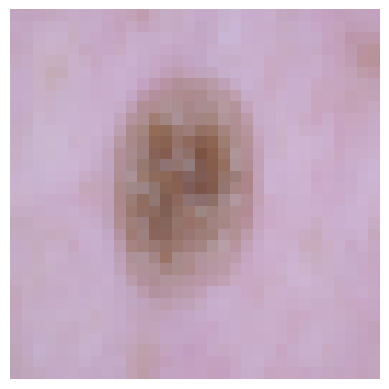

In [11]:
# example of plotting an image
img = df_data['img'].iloc[10]
img = np.transpose(img, (1, 2, 0))
plt.imshow(img, cmap = "Greys_r")
plt.gca().axis("off")
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_data[['lesion_id', 'img']], df_data['dx'], test_size=0.2, random_state=42)

# X_train has lesion_id and img
X_train.head()

,lesion_id,img
1156,HAM_0000827,"[[[168, 176, 178, 179, 178, 185, 184, 184, 191..."
373,HAM_0001389,"[[[140, 148, 154, 163, 165, 171, 172, 172, 173..."
5382,HAM_0002885,"[[[242, 234, 240, 244, 244, 245, 247, 246, 246..."
6162,HAM_0002309,"[[[232, 233, 236, 236, 237, 237, 239, 239, 240..."
7735,HAM_0006567,"[[[183, 182, 184, 185, 187, 190, 190, 191, 192..."


### First Logistic Regression Model

How does a simple logistic regression model perform on images flattened into a list of pixel color values?

In [14]:
n, p = X_train.shape[0], X_train.shape[1] - 1

img_tensors = [torch.Tensor(img) for img in X_train['img'].values]
X_train['img_tensor'] = img_tensors
print(X_train.shape)

img_tensors_tst = [torch.Tensor(img) for img in X_test['img'].values]
X_test['img_tensor'] = img_tensors_tst
print(X_test.shape)

X_train_flat = torch.stack([img.flatten() for img in X_train['img_tensor']])
X_train_flat.shape

C:\Users\julia\AppData\Local\Temp\ipykernel_28632\3824429122.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\b\abs_6fueooay2f\croot\pytorch-select_1707342446212\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img_tensors = [torch.Tensor(img) for img in X_train['img'].values]


(6431, 3)
(1608, 3)


torch.Size([6431, 3072])

Investigate class distribution in y_train to determine baseline accuracy 

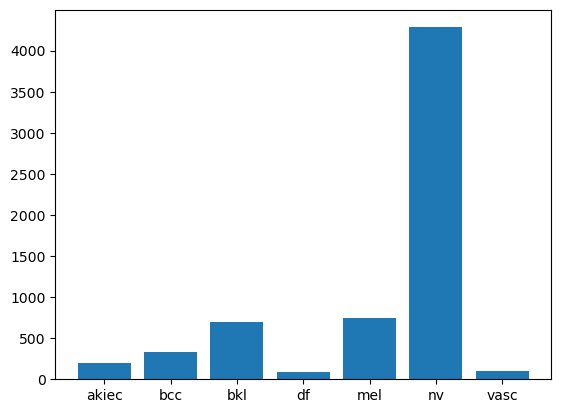

In [18]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
le = LabelEncoder()

# Fit the label encoder and transform y_train
y_train_encoded = le.fit_transform(y_train)

# Now you can count the occurrences of each class
counts = np.bincount(y_train_encoded)

# Create a bar plot
plt.bar(range(len(counts)), counts)

# Add labels
plt.xticks(range(len(counts)), le.classes_)

# Show the plot
plt.show()

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)

LR = LogisticRegression(max_iter=10000)
f = LR.fit(X_train_scaled, y_train)


In [20]:
# display the score
print(f"Score: {f.score(X_train_scaled, y_train)}")

Score: 0.980718395272897


In [285]:
X_train_flat

tensor([[168., 176., 178.,  ...,  90.,  56.,  31.],
        [140., 148., 154.,  ..., 124., 109.,  93.],
        [242., 234., 240.,  ..., 151., 147., 145.],
        ...,
        [215., 218., 220.,  ..., 118., 116., 109.],
        [164., 168., 172.,  ..., 153., 139., 137.],
        [145., 153., 154.,  ..., 166., 166., 159.]])

In [286]:
LR.score(X_train_flat, y_train)

0.7017571139791634

### Convolutional Neural Net
We already flattened the data, so that's pretty cool!

In [287]:
from torch.nn import Conv2d, MaxPool2d, Parameter
from torch.nn.functional import relu

import torch.nn as nn
from  torch.nn import ReLU

In [288]:
print(X_train['img'].iloc[0].shape)
print(X_test['img'].iloc[0].shape)

(3, 32, 32)
(3, 32, 32)


In [289]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit the encoder on the training data
le.fit(y_train)

# Transform y_train and y_test using the fitted encoder
y_train = le.transform(y_train)
y_test = le.transform(y_test)

LEClasses = le.classes_

# Print the classes and their encoded values
for index, label in enumerate(le.classes_):
    print(f'Encoded Value: {index}, Class: {label}')

Encoded Value: 0, Class: akiec
Encoded Value: 1, Class: bcc
Encoded Value: 2, Class: bkl
Encoded Value: 3, Class: df
Encoded Value: 4, Class: mel
Encoded Value: 5, Class: nv
Encoded Value: 6, Class: vasc


In [290]:
X_train_img = torch.stack([torch.from_numpy(img) for img in X_train['img'].tolist()])
y_train = torch.Tensor(y_train.tolist())

X_test_img = torch.stack([torch.from_numpy(img) for img in X_test['img'].tolist()])
y_test = torch.Tensor(y_test.tolist())

In [291]:
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_img, y_train),
    batch_size = 100,
    shuffle = True
)

data_loader_val = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_img, y_test),
    batch_size = 100,
    shuffle = True
)

X, y = next(iter(data_loader_train))

In [292]:
def evaluate(model, multichannel = False):

    # count the number of total observations and correct predictions
    total = 0
    total_correct = 0

    # loop through the data loader
    for X, y in data_loader_val:
        X = X.float()
        y = y.long()

        # used for evaluating ImageNet later
        if multichannel:
            X = torch.tile(X, dims = (1, 3, 1, 1))

        # move the data to the device (ideally, to gpu)

        # compute the predictions
        scores = model.forward(X)
        y_pred =  torch.argmax(scores, dim = 1)

        # update the total and the number of correct predictions
        total += X.size(0)
        total_correct += (y_pred == y).sum().item()

    print(f"validation accuracy = {total_correct / total:.3f}")
#--

In [293]:
import torch.optim as optim
def train(model, k_epochs = 1, print_every = 2000, evaluate_after_epoch = True, multichannel = False, **opt_kwargs):

        # loss function is cross-entropy (multiclass logistic)
    loss_fn = nn.CrossEntropyLoss()

    # optimizer is SGD with momentum
    optimizer = optim.SGD(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            X = X.float()
            y = y.long()
            
            if multichannel:
                X = torch.tile(X, dims = (1, 3, 1, 1))

            # clear any accumulated gradients
            optimizer.zero_grad()

            # compute the loss
            y_pred = model(X)
            loss   = loss_fn(y_pred, y)

            # compute gradients and carry out an optimization step
            loss.backward()
            optimizer.step()

            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model)

In [294]:
class ConvNet_Simplest(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 32)
        )

    def forward(self, x):
        return self.pipeline(x)
    
class ConvNet_class(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(3, 100, 5),
            ReLU(),
            nn.Conv2d(100, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(800, 512),
            ReLU(),
            nn.Linear(512, 128),
            ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        return self.pipeline(x)

class ConvNet_Dropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(3, 100, 5),
            ReLU(),
            nn.Conv2d(100, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.25),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.Conv2d(50, 50, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            #nn.Dropout(0.05),
            nn.Flatten(),
            nn.Linear(800, 512),
            ReLU(),
            nn.Linear(512, 128),
            ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        return self.pipeline(x)

Start with a very simple neural network:

In [295]:
model = ConvNet_Simplest()
from torchsummary import summary
summary(model, input_size=(3, 32, 32))
train(model, k_epochs = 15, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 32]          98,336
Total params: 98,336
Trainable params: 98,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.38
Estimated Total Size (MB): 0.41
----------------------------------------------------------------
Epoch 0: validation accuracy = 0.607
Epoch 1: validation accuracy = 0.640
Epoch 2: validation accuracy = 0.654
Epoch 3: validation accuracy = 0.590
Epoch 4: validation accuracy = 0.450
Epoch 5: validation accuracy = 0.618
Epoch 6: validation accuracy = 0.655
Epoch 7: validation accuracy = 0.654
Epoch 8: validation accuracy = 0.584
Epoch 9: validation accuracy = 0.178
Epoch 10: validation accuracy = 0.320
Epoch 11: validation

What about the model we used in class?

In [296]:
model = ConvNet_class()
#train(model, k_epochs = 2, lr = 0.01, evaluate_after_epoch = True, momentum = 0.9)

What if we try including dropout?

In [297]:
model = ConvNet_Dropout()
#train(model, k_epochs = 2, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

Let's try a model as recommended by a scientific paper on this problem

In [298]:
import torch.nn.functional as F

class ConvNet_Expert(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 7),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.pipeline(x)

In [299]:
model = ConvNet_Expert()
#train(model, k_epochs = 2, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

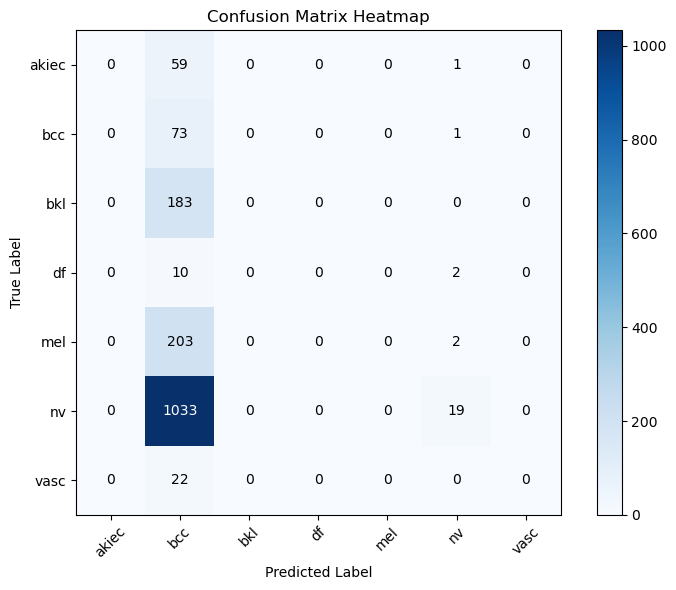

In [300]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming that data_loader is your test data loader
def get_all_preds(model, data_loader_val):
    all_preds = torch.tensor([])
    for batch in data_loader_val:
        images, labels = batch

        # Convert images to float
        images = images.float()

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

with torch.no_grad():
    model.eval()
    y_pred = get_all_preds(model, data_loader_val)
    y_pred = np.argmax(y_pred, axis=1)

# Assuming that y_test are your true labels
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.colorbar()
plt.xticks(np.arange(len(LEClasses)), LEClasses, rotation = 45)
plt.yticks(np.arange(len(LEClasses)), LEClasses)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Because 60% of our data is of class "nv," our model is predicting this class every time.

### Apply class weights

One way we can adjust our model to work with our unbalanced dataset is to apply class weights.

In [301]:
# grab class counts for weights
class_counts = df_data['dx'].value_counts().sort_index()
class_counts_list = class_counts.values.tolist()

# confirmed: these are in the correct order as the label encoder!
class_counts

dx
akiec     260
bcc       402
bkl       875
df         95
mel       948
nv       5336
vasc      123
Name: count, dtype: int64

In [302]:
# Calculate weights -- inversely proportional to class frequencies, so more importance given to under-represented classes
weights = 1. / torch.tensor(class_counts_list, dtype=torch.float)
weights

tensor([0.0038, 0.0025, 0.0011, 0.0105, 0.0011, 0.0002, 0.0081])

In [303]:
def train(model, class_weights, k_epochs = 1, print_every = 2000, evaluate_after_epoch = True, multichannel = False, **opt_kwargs):

    # Convert class_weights to a tensor
    class_weights = torch.tensor(class_weights)

    # loss function is cross-entropy (multichannel logistic) with class weights
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    # optimizer is SGD with momentum
    optimizer = torch.optim.Adam(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            X = X.float()
            y = y.long()
            
            if multichannel:
                X = torch.tile(X, dims = (1, 3, 1, 1))

            # clear any accumulated gradients
            optimizer.zero_grad()

            # compute the loss
            y_pred = model(X)
            loss   = loss_fn(y_pred, y)

            # compute gradients and carry out an optimization step
            loss.backward()
            optimizer.step()

            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model)

In [304]:
model = ConvNet_Expert()
train(model, weights, k_epochs = 5, lr = 0.1, evaluate_after_epoch = True, momentum = 0.9)

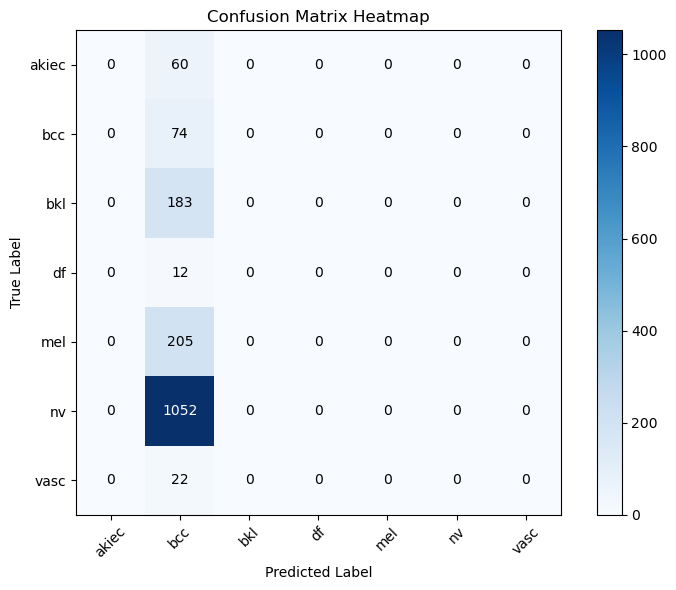

In [305]:
with torch.no_grad():
    model.eval()
    y_pred = get_all_preds(model, data_loader_val)
    y_pred = np.argmax(y_pred, axis=1)
    
# Assuming that y_test are your true labels
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.colorbar()
plt.xticks(np.arange(len(LEClasses)), LEClasses, rotation = 45)
plt.yticks(np.arange(len(LEClasses)), LEClasses)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Ok, at least we're not just predicting nv now! 

### Transfer Learning 

In [306]:
from torchvision import models
model = models.resnet18(weights='IMAGENET1K_V1')

In [307]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

In [308]:
train(model, class_weights=weights, k_epochs = 2,  lr = 0.01, evaluate_after_epoch = True, multichannel = False)

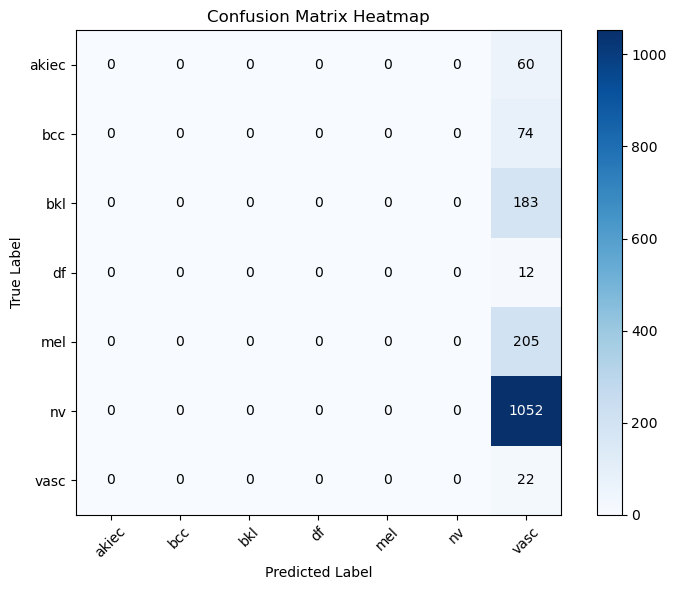

In [309]:
with torch.no_grad():
    model.eval()
    y_pred = get_all_preds(model, data_loader_val)
    y_pred = np.argmax(y_pred, axis=1)
    
# Assuming that y_test are your true labels
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.colorbar()
plt.xticks(np.arange(len(LEClasses)), LEClasses, rotation = 45)
plt.yticks(np.arange(len(LEClasses)), LEClasses)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()